# Running Local LLMs on HPC

Michael Yu-Chuan Hsu, MIT, 2024 mkychsu@MIT.EDU

Markus J. Buehler, MIT, 2024 mbuehler@MIT.EDU



In [1]:
# Run the command here (with !) or on terminal (without !) to start serving a local language model with vllm:
# !vllm serve --served-model-name Llama3.1 --max-model-len 40000 ~/Meta-Llama-3.1-8B-Instruct-Q4_K_L.gguf

### checking if the llm is running on the portal (default: 8000)

In [1]:
!curl http://localhost:8000/v1/models

curl: (7) Failed to connect to localhost port 8000 after 0 ms: Couldn't connect to server


In [10]:
import openai
config_list = [
    {
        "model":"Llama3.1",
        "base_url": "http://localhost:8000/v1",
        "api_key":"NULL",
        "max_tokens": 10000
    },
]

## Method 1a: calling the model directly with API

In [12]:
from openai import OpenAI
# Defaults to os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key=config_list[0]["api_key"],
                base_url=config_list[0]["base_url"],
                )

completion = client.chat.completions.create(
    messages=[
        {"role": "user", "content": "Give me an example of LAMMPS script"},
        {"role": "system",  "content": "You are an expert in this field. Try your best to give a clear and concise answer."},
    ],
    model= config_list[0]["model"]
)

In [13]:
print(completion.choices[0].message.content)

Here's an example of a basic LAMMPS script:

```lmpscript
# Define the units system
units           real       m           # units of length in meters
units           energy     J           # units of energy in joules
units           time       s           # units of time in seconds
units           temperature K           # units of temperature in Kelvin

# Define the simulation box
boundary        p          x           # periodic boundary conditions in x-direction
boundary        p          y           # periodic boundary conditions in y-direction
boundary        p          z           # periodic boundary conditions in z-direction

# Define the atoms
atom_style      atomic     # use atomic style
atom_modify     mass       1.0        # mass of each atom
atom_modify     sort       1.0        # sort atoms by ID

# Define the potential
pair_style      lj/charmm   # use Lennard-Jones potential
pair_coeff      1 1   1.0  1.0  # Lennard-Jones parameters for atom 1

# Define the integrator
t

## Method 1b: calling the model with a wrapper function with API

#### As an object, it can be sent to other implemented functions easily.

In [14]:
from openai import OpenAI
class llm:
    def __init__(self, llm_config):
        self.client = OpenAI(api_key=llm_config["api_key"],
                             base_url=llm_config["base_url"],
                             )
        self.model = llm_config["model"]
        self.max_tokens = llm_config["max_tokens"]
        
    def generate_cli(self, system_prompt="You are an expert in this field. Try your best to give a clear and concise answer.", 
                           prompt="Hello world! I am", temperature=0,
                           ):     
        try:
            if system_prompt==None:
                messages=[
                    {"role": "user", "content": prompt},

                ]

            else:
                messages=[
                    {"role": "system",  "content": system_prompt},
                    {"role": "user", "content": prompt},

                ]
            result=self.client.chat.completions.create(
                    model=self.model,
                    messages=messages,
                    temperature=temperature,
                    max_tokens=self.max_tokens,
                )

            return result.choices[0].message.content
        except:
            return ''
        

In [15]:
llm=llm(llm_config=config_list[0])

In [16]:
generate = llm.generate_cli

In [18]:
import time
q="Give me an example of LAMMPS script"
start_time = time.time()
res=generate( system_prompt='You are an expert in this field. Try your best to give a clear and concise answer.', 
         prompt=q,temperature=0,  )

deltat=time.time() - start_time
print("--- %s seconds ---" % deltat)
print(res)

--- 4.34918737411499 seconds ---
LAMMPS (Large-scale Atomic/Molecular Massively Parallel Simulator) is a molecular dynamics simulation software. Here's an example of a simple LAMMPS script that simulates a 2D Lennard-Jones fluid:

```lmp
# LAMMPS script to simulate a 2D Lennard-Jones fluid

# Define the units
units lj

# Define the mass of the particles
mass 1.0

# Define the charge of the particles (not used in this example)
charge 0.0

# Define the pair potential (Lennard-Jones)
pair_style lj 1.0 1.0

# Define the pair potential cutoff
pair_modify shift yes

# Define the boundary conditions
boundary p p p

# Define the simulation box
region box block 0 10 0 10 0 10

# Define the number of particles
variable n equal 1000

# Define the particle positions
variable x equal uniform(-5 5)
variable y equal uniform(-5 5)

# Define the particle velocities
variable vx equal uniform(-1 1)
variable vy equal uniform(-1 1)

# Define the simulation time
timestep 0.001
run 10000

# Output the partic

## Method 2: running the model in the current session

In [2]:
from vllm import LLM, SamplingParams

/home/mkychsu/pool/.conda/envs/llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-12 04:54:07,476	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [28]:
max_model_len = 40000
sampling_params = SamplingParams(temperature=0, top_p=0.8, top_k=5,
                                max_tokens=max_model_len, presence_penalty=1.1)

In [5]:
llm = LLM(model="/home/mkychsu/pool/llm/Meta-Llama-3.1-8B-Instruct-Q4_K_L.gguf", max_model_len=max_model_len, enable_chunked_prefill=False)

INFO 11-12 04:58:13 config.py:1664] Downcasting torch.float32 to torch.float16.
WARNING 11-12 04:58:18 config.py:321] gguf quantization is not fully optimized yet. The speed can be slower than non-quantized models.
WARNING 11-12 04:58:18 arg_utils.py:967] The model has a long context length (40000). This may cause OOM errors during the initial memory profiling phase, or result in low performance due to small KV cache space. Consider setting --max-model-len to a smaller value.
INFO 11-12 04:58:18 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='/home/mkychsu/pool/llm/Meta-Llama-3.1-8B-Instruct-Q4_K_L.gguf', speculative_config=None, tokenizer='/home/mkychsu/pool/llm/Meta-Llama-3.1-8B-Instruct-Q4_K_L.gguf', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=40000, download_dir=None, load_format=LoadF

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


INFO 11-12 04:59:02 selector.py:224] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 11-12 04:59:02 selector.py:115] Using XFormers backend.


/home/mkychsu/pool/.conda/envs/llm/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/mkychsu/pool/.conda/envs/llm/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


INFO 11-12 04:59:03 model_runner.py:1056] Starting to load model /home/mkychsu/pool/llm/Meta-Llama-3.1-8B-Instruct-Q4_K_L.gguf...
INFO 11-12 04:59:13 selector.py:224] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 11-12 04:59:13 selector.py:115] Using XFormers backend.


/home/mkychsu/pool/.conda/envs/llm/lib/python3.10/site-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


INFO 11-12 04:59:24 model_runner.py:1067] Loading model weights took 5.0173 GB
INFO 11-12 05:00:43 gpu_executor.py:122] # GPU blocks: 8114, # CPU blocks: 2048
INFO 11-12 05:00:43 gpu_executor.py:126] Maximum concurrency for 40000 tokens per request: 3.25x
INFO 11-12 05:00:45 model_runner.py:1395] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 11-12 05:00:45 model_runner.py:1399] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 11-12 05:01:14 model_runner.py:1523] Graph capturing finished in 29 secs.


In [29]:
res=llm.chat(
    messages=[
        {"role": "system",  "content": "You are an expert in this field. Try your best to give a clear and concise answer."},
        {"role": "user", "content": "Give me an example of LAMMPS script"},
    ],
    sampling_params=sampling_params
)


Processed prompts: 100%|██████████| 1/1 [00:05<00:00,  5.07s/it, est. speed input: 13.43 toks/s, output: 90.84 toks/s]


In [30]:
print(res[0].outputs[0].text)

LAMMPS (Large-scale Atomic/Molecular Massively Parallel Simulator) is a molecular dynamics simulation software. Here's an example of a simple LAMMPS script that simulates a 2D Lennard-Jones fluid:

```lmp
# Define the simulation box dimensions
units lj
boundary p p p

# Define the number of particles and their properties
atom_style atomic
atom_modify map array

# Define the Lennard-Jones potential parameters
pair_style lj 12 6 cut 1.0

# Define the pair coefficients
pair_coeff * * 1.0 1.0

# Define the simulation time step and run duration
timestep 0.005
run 10000

# Output the final configuration
dump 1 all atom 10000 dump.lammpstrj
```

This script does the following:

1.  **Defines the simulation box dimensions**: The `units` command sets the units of length to be in terms of the Lennard-Jones unit, which is defined as the distance at which the Lennard-Jones potential is zero. The `boundary` command specifies periodic boundary conditions in all three dimensions.
2.  **Sets up the si

In [ ]:
from llama_cpp import Llama
from llama_cpp.llama_chat_format import Llama3VisionAlphaChatHandler
chat_handler = Llama3VisionAlphaChatHandler(clip_model_path="/home/mkychsu/pool/llm/llama-3-vision-alpha")
llm = Llama(
  model_path=" ~/pool/llm/llama-3-vision-alpha-mmproj-f16.gguf",
  chat_handler=chat_handler,
  n_ctx=2048, # n_ctx should be increased to accommodate the image embedding
)
llm.create_chat_completion(
    messages = [
        {"role": "system", "content": "You are an assistant who perfectly describes images."},
        {
            "role": "user",
            "content": [
                {"type" : "text", "text": "What's in this image?"},
                {"type": "image_url", "image_url": {"url": "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Gfp-wisconsin-madison-the-nature-boardwalk.jpg/2560px-Gfp-wisconsin-madison-the-nature-boardwalk.jpg" } }
            ]
        }
    ]
)

In [2]:
model_id = "/home/mkychsu/pool/llm/Cephalo-Phi-3-vision-128k-4b-alpha"

In [3]:
from PIL import Image 
import requests 
from transformers import AutoModelForCausalLM 
from transformers import AutoProcessor 

# model_id = "lamm-mit/Cephalo-Phi-3-vision-128k-4b-beta" 

model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto")

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True) 


Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.06s/it]
/home/mkychsu/pool/.conda/envs/llm/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:517: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [4]:
import glob
papers = glob.glob(f'./paper_new/*[!pdf]')
paper = papers[2]

pngs = glob.glob(f'{paper}/*png')
pngs

['./paper_new/Model analysis of the feature profile evolution during Si etching in HBr-containing plasmas/0_image_0.png',
 './paper_new/Model analysis of the feature profile evolution during Si etching in HBr-containing plasmas/0_image_1.png',
 './paper_new/Model analysis of the feature profile evolution during Si etching in HBr-containing plasmas/0_image_2.png',
 './paper_new/Model analysis of the feature profile evolution during Si etching in HBr-containing plasmas/0_image_3.png',
 './paper_new/Model analysis of the feature profile evolution during Si etching in HBr-containing plasmas/0_image_4.png',
 './paper_new/Model analysis of the feature profile evolution during Si etching in HBr-containing plasmas/0_image_5.png',
 './paper_new/Model analysis of the feature profile evolution during Si etching in HBr-containing plasmas/0_image_6.png',
 './paper_new/Model analysis of the feature profile evolution during Si etching in HBr-containing plasmas/3_image_0.png',
 './paper_new/Model anal

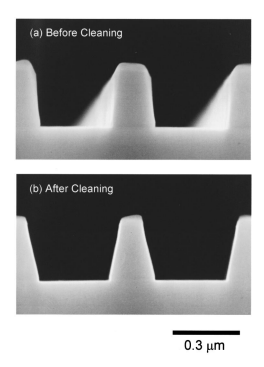

In [5]:
image = Image.open('./paper_new/Profile evolution during polysilicon gate etching with low-pressure high-density cl2 hbr o2  plasma chemistries/4_image_0.png')
image

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
/home/mkychsu/.cache/huggingface/modules/transformers_modules/microsoft/Phi-3-vision-128k-instruct/c45209e90a4c4f7d16b2e9d48503c7f3e83623ed/image_embedding_phi3_v.py:197: UserWarning: Phi-3-V modifies `input_ids` in-place and the tokens indicating images will be removed after model forward. If your workflow requires multiple forward passes on the same `input_ids`, please make a copy of `input_ids` before passing it to the model.
  warnings.warn(
You are not running the flash-attention implementation, expect numerical differences.


The image shows a comparison of the surface morphology of a material before and after cleaning. 

(a) Before Cleaning: The image displays a surface with a rough texture, characterized by multiple peaks and valleys. The scale bar indicates a length of 0.3 micrometers (µm).

(b) After Cleaning: The image shows a significantly smoother surface with fewer and less pronounced peaks and valleys. The scale bar remains the same, indicating the same length of 0.3 micrometers.

The logical reasoning behind these observations is that the cleaning process likely removed contaminants or residues from the surface, resulting in a smoother and more uniform surface morphology. This improvement in surface quality can enhance the material's performance in various applications, such as reducing friction, improving adhesion, or altering optical properties.


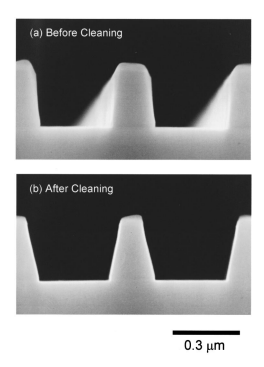

In [6]:

question = f"Explain concisely with details about the scientific fact shown in this image"

messages = [ 
    {"role": "user", "content": f"<|image_1|>\n{question}"}, 
    ] 

# url = "https://www.quantamagazine.org/wp-content/uploads/2018/02/Ants_Lede1300.jpg" 

# image = Image.open(requests.get(url, stream=True).raw) 

# image = Image.open('./paper_new/Profile evolution during polysilicon gate etching with low-pressure high-density cl2 hbr o2  plasma chemistries/4_image_0.png')

prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0") 

generation_args = { 
                    "max_new_tokens": 512, 
                    "temperature": 0.1, 
                    "do_sample": True, 
                    "stop_strings": ['<|end|>',
                                     '<|endoftext|>'],
                    "tokenizer": processor.tokenizer,
                  } 

generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args) 

# remove input tokens 
generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0] 

print(response)
image

The image shows two cross-sectional Scanning Electron Microscope (SEM) micrographs of poly-Si line-and-space features before and after cleaning. 

In the first micrograph (a), labeled "Before Cleaning," the poly-Si features appear to have a rougher texture and more pronounced surface irregularities. The scale bar indicates a length of 0.3 micrometers (µm).

In the second micrograph (b), labeled "After Cleaning," the poly-Si features appear smoother and more uniform in texture. The scale bar remains the same, indicating a consistent measurement scale.

The cleaning process, which involves using a standard wet clean with ammonia peroxide mixtures, appears to significantly improve the surface quality of the poly-Si features. This is evident from the more uniform and smoother appearance of the features after cleaning compared to before.


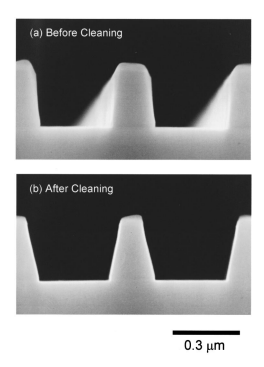

In [8]:

caption = """
FIG. 6. Cross-sectional SEM micrographs of poly-Si line-and-space features

![4_image_0.png](4_image_0.png)

etched in an HBr/O2 plasma ~a! before and ~b! after the removal of deposited films by a standard wet clean with ammonia peroxide mixtures.
lations and compared the experimental and numerical results
"""
question = f"Explain all details of what you see in this image with the corresponding caption: {caption}."

messages = [ 
    {"role": "user", "content": f"<|image_1|>\n{question}"}, 
    ] 

# url = "https://www.quantamagazine.org/wp-content/uploads/2018/02/Ants_Lede1300.jpg" 

# image = Image.open(requests.get(url, stream=True).raw) 

# image = Image.open('./paper_new/Profile evolution during polysilicon gate etching with low-pressure high-density cl2 hbr o2  plasma chemistries/4_image_0.png')

prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0") 

generation_args = { 
                    "max_new_tokens": 512, 
                    "temperature": 0.1, 
                    "do_sample": True, 
                    "stop_strings": ['<|end|>',
                                     '<|endoftext|>'],
                    "tokenizer": processor.tokenizer,
                  } 

generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args) 

# remove input tokens 
generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0] 

print(response)
image

In [1]:
import networkx as nx
import glob
GRAPH_DATA = 'GRAPHDATA_TSMC_v1'
graph_list = glob.glob(f'{GRAPH_DATA}/*.graphml')
graph_name=graph_list[0]
G = nx.read_graphml(graph_name)

In [10]:
from PIL import Image, ImageFilter

In [11]:
def seacrh_case_insensitive(fname):
    buffer = []
    for s in fname:
        if s.lower() != s.upper():
            buffer.append(f'[{s.upper()}{s.lower()}]')
        else:
            buffer.append(s)
    search_str = ''.join(buffer)
    return glob.glob(search_str)

In [63]:
def graph_load_images(G):
    node_list = list(G.nodes)
    for node in node_list:
        if '.png' in node:
            try:
                image_name=seacrh_case_insensitive(node)[0]
            except:
                continue
                
            # G.add_node(node, image = Image.open(image_name))
            G.add_node(node, image = Image.open(image_name).filter(ImageFilter.ModeFilter(7)))
            print(f'Adding image {image_name}')
  
    return G

In [64]:
G = graph_load_images(G)

Adding image ./paper/handbook-of-silicon-wafer-cleaning-technology-third-edition_compress/243_image_0.png
Adding image ./paper/handbook-of-silicon-wafer-cleaning-technology-third-edition_compress/274_image_0.png
Adding image ./paper/handbook-of-silicon-wafer-cleaning-technology-third-edition_compress/280_image_0.png
Adding image ./paper/handbook-of-silicon-wafer-cleaning-technology-third-edition_compress/306_image_0.png
Adding image ./paper/handbook-of-silicon-wafer-cleaning-technology-third-edition_compress/326_image_0.png
Adding image ./paper/handbook-of-silicon-wafer-cleaning-technology-third-edition_compress/333_image_0.png
Adding image ./paper/handbook-of-silicon-wafer-cleaning-technology-third-edition_compress/357_image_0.png
Adding image ./paper/handbook-of-silicon-wafer-cleaning-technology-third-edition_compress/366_image_1.png
Adding image ./paper/handbook-of-silicon-wafer-cleaning-technology-third-edition_compress/441_image_0.png
Adding image ./paper/handbook-of-silicon-wafer

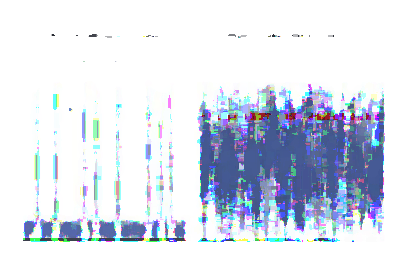

In [65]:
image_name = './paper/handbook-of-silicon-wafer-cleaning-technology-third-edition_compress/698_image_3.png'
Image.open(image_name).filter(ImageFilter.ModeFilter(7))
# Image.open(image_name).filter(ImageFilter.MultibandFilter)
# PIL.ImageFilter.MultibandFilter

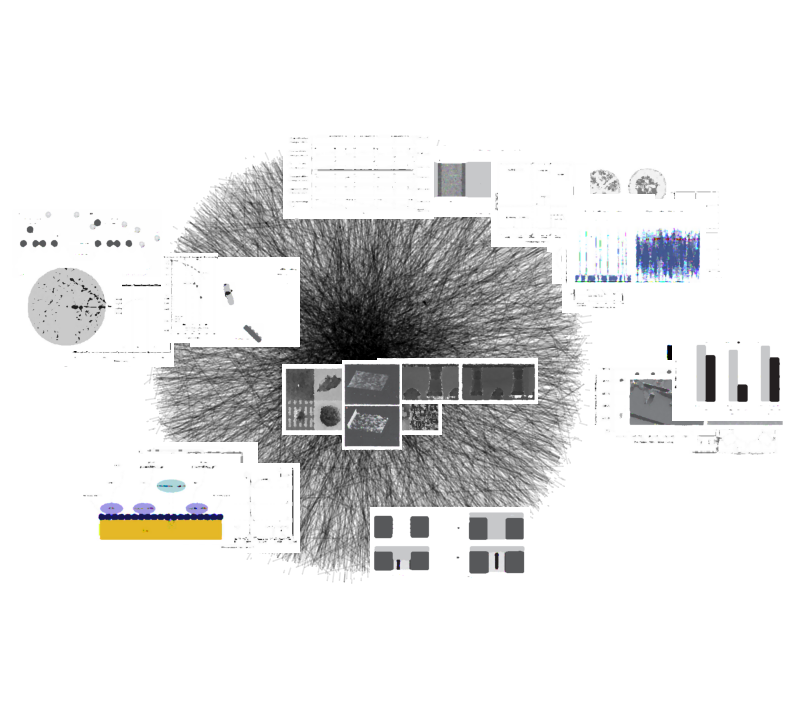

In [66]:
import matplotlib.pyplot as plt
# pos=nx.circular_layout(G)
# pos=nx.random_layout(G)
pos=nx.spring_layout(G)
fig=plt.figure(figsize=(16,9))

ax=plt.subplot(111)
ax.set_aspect('equal')
nx.draw_networkx_edges(G,pos,ax=ax, arrowsize=0.1,alpha=0.1)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)

trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

piesize=0.1 # this is the image size
p2=piesize/2.0
for n in G:
    try:
        image = G.nodes[n]['image']
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
 
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(image)
        a.axis('off')
    except:
        pass
ax.axis('off')
plt.savefig('multimodal_graph.png')

plt.show()